# Modeling Yelp Reviews of Cafes Near San Francisco

Paul Lim

## Libraries

In [1]:
# Main imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# sklearn
from sklearn.pipeline import make_pipeline
from sklearn import pipeline, feature_selection, decomposition
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import DBSCAN, AgglomerativeClustering, Birch
from sklearn.decomposition import PCA, NMF
from sklearn.metrics import silhouette_score

# NLP 
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy
import gensim
from gensim import models
from gensim.models import word2vec
import snowballstemmer

# Misc.
import re
import datetime
import time
import logging
import math

% matplotlib inline

sns.set_style("white")
sns.set_style('ticks')
sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})
sns.set_style({'legend.frameon': True})

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/home/plim0793/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Running List of Functions/Classes

### Classes

In [2]:
class DataframeToSeriesTransformer(BaseEstimator, TransformerMixin):
        
    def __init__(self, col=None):
        self.col = col
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.col:
            print("DTST: ", X[self.col].shape)
            return X[self.col]
        else:
            return X
        
class SeparateFeaturesTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_cols=None, text_cols=None):
        self.num_cols = num_cols
        self.text_cols = text_cols
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.num_cols:
            print("SFT: ", X.loc[:, self.num_cols].shape)
            return X.loc[:, self.num_cols]
        elif self.text_cols:
            print("SFT: ", X.loc[:, self.text_cols].shape)
            return X.loc[:, self.text_cols]
        else:
            return X
        
class WilsonAverageTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_col=None, biz_list=None):
        self.num_col = num_col
        self.biz_list = biz_list
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.num_col and self.biz_list.all():
            scores = get_average_rating(X, self.biz_list)
            
            X_avg = pd.DataFrame({'average': scores})
            print("WAT: ", X_avg.shape)
            return X_avg
        else:
            return X
        
class CleanTextTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, text_col=None):
        self.text_col = text_col
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
#         NLP = spacy.load('en')
#         stemmer = snowballstemmer.EnglishStemmer()
#         stop = stopwords.words('english')
#         stop_list = stemmer.stemWords(stop)
#         stop_list = set(stop_list)
#         stop = set(stop + list(stop_list))
        X_list = X.loc[:, self.text_col].tolist()
        
        if self.text_col:
            df = pd.DataFrame()
            clean_review_list = []
            
            for review in X_list:
                clean_review = ''
                
                for word in TextBlob(review).words:
#                     if word not in stop:
                    clean_review += word.lemmatize() + ' '
                        
#                 clean_review = NLP(clean_review)
                clean_review_list.append(clean_review)
                        
            df['clean_reviews'] = clean_review_list
            print("CTT: ", df.shape)
            return df
        else:
            return X
        
class DensifyTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = pd.DataFrame(X.toarray())
        print("DT: ", df.shape)
        return df
    
class SentimentTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_col=None):
        self.text_col = text_col
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.text_col:
            df = pd.DataFrame()
            sum_pol_list = []
            sum_sub_list = []
            doc_list = X.loc[:, self.text_col].tolist()

            for doc in doc_list:
                sum_pol = 0
                sum_sub = 0
                doc_blob = TextBlob(doc)

                for sent in doc_blob.sentences:
                    sum_pol += sent.sentiment[0]
                    sum_sub += sent.sentiment[1]

                sum_pol_list.append(sum_pol)
                sum_sub_list.append(sum_sub)

            df['pol'] = sum_pol_list
            df['sub'] = sum_sub_list
            df['clean_reviews'] = X.loc[:, self.text_col] # Need to keep the clean reviews for the W2V transformer.
            print("ST: ", df.shape)
            return df
        else:
            return X

class Word2VecTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_col=None, w2v=None):
        self.text_col = text_col
        self.w2v = w2v
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.text_col:
            avg_w2v_list = []
            review_list = X.loc[:, self.text_col].tolist()
            
            for review in review_list:
                avg_w2v = np.zeros(300)
                count = 0
                
                for word in review:
                    try:
                        avg_w2v += w2v.word_vec(word)
                        count += 1
                    except Exception:
                        continue

                avg_w2v_list.append(avg_w2v/count)
            df = pd.DataFrame(avg_w2v_list)
#             print(df.head())
            print("W2V: ", df.shape)
            return df
        else:
            return X
        
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        df = pd.DataFrame(X)
#         print(df.head())
        print("TDFT: ", df.shape)
        return df
        
class DropTextTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_col=None):
        self.text_col = text_col
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.text_col:
            df = X.drop(self.text_col, axis=1)
            print("DTT: ", df.shape)
            return df

### Functions

In [3]:
def confidence(pos, neg):
    '''
    Calculates the Wilson confidence where pos is the number of positive ratings
    and neg is the number of negative ratings.
    '''
    n = pos + neg
    
    if n == 0:
        return 0
    z = 1.96 # 95% confidence interval
    phat = float(pos) / n
    return (((phat + z*z/(2*n) - z * np.sqrt((phat*(1-phat)+z*z/(4*n))/n))/(1+z*z/n)))

def get_average_rating(df, biz_list):
    '''
    Compiles the list of average ratings for each business in biz_list.
    '''
    wils_list = []
    
    for biz in biz_list:
        ind_biz = df[df['name'] == biz]
        
        pos_count = 0
        neg_count = 0
        
        for rating in ind_biz['rating']:
            if rating > 3:
                pos_count += 1
            else:
                neg_count += 1
        
        wils_conf = confidence(pos_count, neg_count)
        wils_list.append(wils_conf)
    return wils_list

def sample_cluster(df, group_by_cols, size=5):
    sample_fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace=True), :]
    df = df.groupby(group_by_cols, as_index=False).apply(sample_fn)
    
    return df

def get_metrics(pipe, model, df_orig):
    df_transformed = pipe.fit_transform(df_orig)
#     print(df_transformed[0])
    pred = model.fit_predict(df_transformed)
    print("Number of Clusters: ", len(np.unique(pred)))
    print("Silhouette Coefficient: %0.3f" % silhouette_score(df_transformed, model.labels_))
    return df_transformed, pred

def model_metrics(model_dict, pipe, df):

    model_dfs = {}
    for name, model in model_dict.items():
        print(name)
        temp_df, temp_score = get_metrics(pipe, model, df)
        model_dfs[name] = [temp_df, temp_score]
    return model_dfs

## Data Preprocessing

### Load in data

#### Applies to local computer

In [4]:
df_init = joblib.load('../data/df_tot')

#### Applies to AWS

In [4]:
df_init = joblib.load('/home/plim0793/df_tot')

In [5]:
df_init.shape

(204696, 3)

### Reorder columns

In [5]:
df_init = df_init[['name', 'rating' ,'reviews']]

### Change rating to int type

In [6]:
df_init['rating'] = df_init['rating'].apply(lambda x: int(x))

### Create transformers for splitting text and num columns

In [8]:
t = SeparateFeaturesTransformer(text_cols=['reviews'])
n = SeparateFeaturesTransformer(num_cols=['rating'])

print(t.transform(df_init).head())
print(n.transform(df_init).head())

SFT:  (204696, 1)
                                             reviews
0  Hipster coffee galore! What happened to just a...
1  A pretty hipster, modern spacious place to do ...
2  Great place to grab a coffee and you can get t...
3  Coffee is amazing! Overpriced as usual. There'...
4  Big time coffee lover. First time customer and...
SFT:  (204696, 1)
   rating
0       2
1       4
2       5
3       4
4       4


In [9]:
t.transform(df_init).shape
n.transform(df_init).shape

SFT:  (204696, 1)
SFT:  (204696, 1)


(204696, 1)

### Create transformer for averaging ratings for each business (may not need this since I might not average across the each business)

#### Get Wilson average for one business

In [10]:
one_biz = df_init[df_init['name'] == '0_FourBarrelCoffee']

In [11]:
pos_count = 0
neg_count = 0

for rating in one_biz['rating']:
    if rating > 3:
        pos_count += 1
    else:
        neg_count += 1
        
wil_conf = confidence(pos_count, neg_count)

#### Generalize to all businesses

In [12]:
biz_list = df_init['name'].unique()

In [13]:
wils_scores = get_average_rating(df_init, biz_list)

#### Create the transformer class

In [14]:
wat = WilsonAverageTransformer(num_col='rating', biz_list=biz_list)

In [15]:
wat.transform(df_init)

WAT:  (831, 1)


,average
0,0.726315
1,0.873692
2,0.831345
3,0.733775
4,0.831141
5,0.784363
6,0.720300
7,0.887100
8,0.577846
9,0.938036


### Create a transformer for preprocessing the reviews

#### Get the lemmatized review for just one review

In [ ]:
one_review = df_init.iloc[0, 2]

In [ ]:
nlp = spacy.load('en')

In [ ]:
sample_doc = nlp(one_review)

In [ ]:
clean_doc = ''
for word in sample_doc:
    if word.is_stop == False:
        clean_doc += word.lemma_ + ' '
clean_doc = nlp(clean_doc)

In [ ]:
for sent in clean_doc.sents:
    print(sent)

#### Generalize to all reviews

In [ ]:
test_df = df_init.iloc[:100, :]

In [ ]:
ct = CleanText('reviews')

test_ct = ct.transform(test_df)

In [ ]:
tf = TfidfVectorizer()

tf_t = tf.fit_transform(test_ct.clean_reviews)

In [ ]:
tf_t.todense()

In [ ]:
print(test_ct.clean_reviews[0])

## Build the Pipeline

#### Set a smaller test dataframe (10 samples from each business)

In [7]:
df_test = sample_cluster(df_init, ['name'], size=100)

In [8]:
df_test.shape

(83100, 3)

In [9]:
df_test.head()

name  rating  \
0 52   0_FourBarrelCoffee       5   
  260  0_FourBarrelCoffee       5   
  51   0_FourBarrelCoffee       4   
  134  0_FourBarrelCoffee       5   
  178  0_FourBarrelCoffee       4   

                                                 reviews  
0 52   Four Barrel is hipster AF and their coffee is ...  
  260  A much needed and welcome addition to the Port...  
  51   I was going to a training around the area and ...  
  134  Come to Four Barrel for the ambiance.  Don't g...  
  178  The coffee is awesome but too expensive. Truly...

#### PCA pipeline

In [16]:
# pipe_pca = Pipeline([
#                             ('combined_features', FeatureUnion([

#                                 ('num_feat', SeparateFeaturesTransformer(num_cols=['rating'])),
#                                 ('text_feat', Pipeline([

#                                     ('split_text', SeparateFeaturesTransformer(text_cols=['reviews'])),
#                                     ('clean', CleanTextTransformer('reviews')),
#                                     ('combine_text', FeatureUnion([
                                            
#                                         ('sentiment_analysis', SentimentTransformer(text_col='clean_reviews')),
#                                         ('vectorize', Pipeline([

#                                             ('to_series', DataframeToSeriesTransformer(col='clean_reviews')),
#                                             ('tfidf', TfidfVectorizer(stop_words="english",
#                                                                       token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b",
#                                                                       min_df=10)),
#                                             ('densify', DensifyTransformer()),
#                                             ('pca', PCA(n_components=3))
#                                                             ]))
#                                                                 ])),
#                                     ('to_df', ToDataFrameTransformer()),
#                                     ('drop_text', DropTextTransformer(text_col=2))
#                                                         ]))
#                                                             ]))
#                             ])

pipe_pca = Pipeline([
                     ('text_feat', Pipeline([

                        ('split_text', SeparateFeaturesTransformer(text_cols=['reviews'])),
                        ('clean', CleanTextTransformer('reviews')),
                        ('combine_text', FeatureUnion([

                            ('sentiment_analysis', SentimentTransformer(text_col='clean_reviews')),
                            ('vectorize', Pipeline([

                                ('to_series', DataframeToSeriesTransformer(col='clean_reviews')),
                                ('tfidf', TfidfVectorizer(stop_words="english",
                                                          token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b",
                                                          min_df=10)),
                                ('densify', DensifyTransformer())
                                                ]))
                                                    ])),
                        ('to_df', ToDataFrameTransformer()),
                        ('drop_text', DropTextTransformer(text_col=2)),
                        ('pca', PCA(n_components=2))
                                                ]))
                    ])
                        

#### NMF pipeline

In [17]:
# pipe_nmf = Pipeline([
#                             ('combined_features', FeatureUnion([

#                                 ('num_feat', SeparateFeaturesTransformer(num_cols=['rating'])),
#                                 ('text_feat', Pipeline([

#                                     ('split_text', SeparateFeaturesTransformer(text_cols=['reviews'])),
#                                     ('clean', CleanTextTransformer('reviews')),
#                                     ('combine_text', FeatureUnion([
                                            
#                                         ('sentiment_analysis', SentimentTransformer(text_col='clean_reviews')),
#                                         ('vectorize', Pipeline([

#                                             ('to_series', DataframeToSeriesTransformer(col='clean_reviews')),
#                                             ('tfidf', TfidfVectorizer(stop_words="english",
#                                                                       token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b",
#                                                                       min_df=10)),
#                                             ('densify', DensifyTransformer()),
#                                             ('nmf', NMF(n_components=3))
#                                                             ]))
#                                                                 ])),
#                                     ('to_df', ToDataFrameTransformer()),
#                                     ('drop_text', DropTextTransformer(text_col=2))
#                                                         ]))
#                                                             ]))
#                             ])

pipe_nmf = Pipeline([
                     ('text_feat', Pipeline([

                        ('split_text', SeparateFeaturesTransformer(text_cols=['reviews'])),
                        ('clean', CleanTextTransformer('reviews')),
                        ('combine_text', FeatureUnion([

                            ('sentiment_analysis', SentimentTransformer(text_col='clean_reviews')),
                            ('vectorize', Pipeline([

                                ('to_series', DataframeToSeriesTransformer(col='clean_reviews')),
                                ('tfidf', TfidfVectorizer(stop_words="english",
                                                          token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b",
                                                          min_df=10)),
                                ('densify', DensifyTransformer())
                                                ]))
                                                    ])),
                        ('to_df', ToDataFrameTransformer()),
                        ('drop_text', DropTextTransformer(text_col=2)),
                        ('nmf', NMF(n_components=2))
                                                ]))
                    ])
                        

#### Use the Google word2vec model in place of the tf-idf and PCA steps

##### Applies to local computer

In [13]:
# ONLY RUN ONCE AT THE START OF THE KERNEL
w2v = models.KeyedVectors.load_word2vec_format("~/Documents/GoogleNews-vectors-negative300.bin.gz",binary=True)

2017-05-30 11:27:52,659 : INFO : loading projection weights from ~/Documents/GoogleNews-vectors-negative300.bin.gz
2017-05-30 11:30:36,966 : INFO : loaded (3000000, 300) matrix from ~/Documents/GoogleNews-vectors-negative300.bin.gz


##### Applies to AWS

In [15]:
# ONLY RUN ONCE AT THE START OF THE KERNEL
w2v = models.KeyedVectors.load_word2vec_format("/home/plim0793/GoogleNews-vectors-negative300.bin.gz",binary=True)

2017-05-30 21:32:02,459 : INFO : loading projection weights from /home/plim0793/GoogleNews-vectors-negative300.bin.gz
2017-05-30 21:34:09,843 : INFO : loaded (3000000, 300) matrix from /home/plim0793/GoogleNews-vectors-negative300.bin.gz


In [18]:
pipe_w2v = Pipeline([
                    ('text_feat', Pipeline([

                        ('split_text', SeparateFeaturesTransformer(text_cols=['reviews'])),
                        ('clean', CleanTextTransformer('reviews')),
                        ('sentiment', SentimentTransformer(text_col='clean_reviews')),
                        ('vectorize', Word2VecTransformer(text_col='clean_reviews', w2v=w2v))
                                            ]))
                    ])

NameError: name 'w2v' is not defined

### In order to take a closer look at the text processing steps, a smaller pipeline will be created

#### Set the text processing steps

In [15]:
text_processing = Pipeline([
                ('clean', CleanTextTransformer('reviews')),
                ('to_series', DataframeToSeriesTransformer(col='clean_reviews')),
                ('tfidf', TfidfVectorizer(stop_words="english",
                                          token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b",
                                          min_df=10)),
                ('densify', DensifyTransformer())
            ])

In [12]:
tp = text_processing.fit_transform(df_test)
tp.shape

SFT:  (83100, 1)
SFT:  (83100, 1)
CTT:  (83100, 1)
ST:  (83100, 3)
DTST:  (83100,)
DT:  (83100, 11985)
TDFT:  (83100, 11988)
DTT:  (83100, 11987)


(83100, 2)

#### Run PCA with 2 latent features

In [19]:
pca = PCA(n_components=2)

In [20]:
tpm = pca.fit_transform(tp)

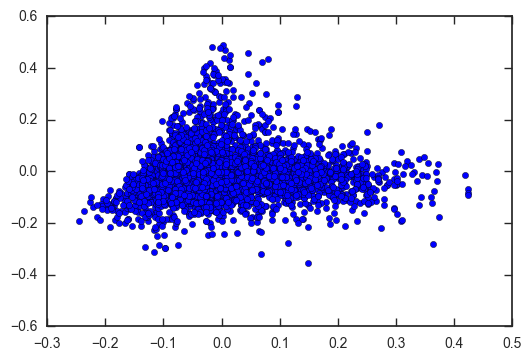

In [21]:
plt.scatter(tpm[:,0], tpm[:,1])

In [22]:
print(pca.explained_variance_ratio_)

[ 0.0102113   0.00851407]


#### Try various numbers of latent features

In [23]:
pca_range = [i for i in range(40)]
pca_variances_cum = []

for num in pca_range:
    pca_obj = PCA(n_components=num)
    pca_fit = pca_obj.fit_transform(tp)
    
    pca_variances_cum.append(sum(pca_obj.explained_variance_ratio_))

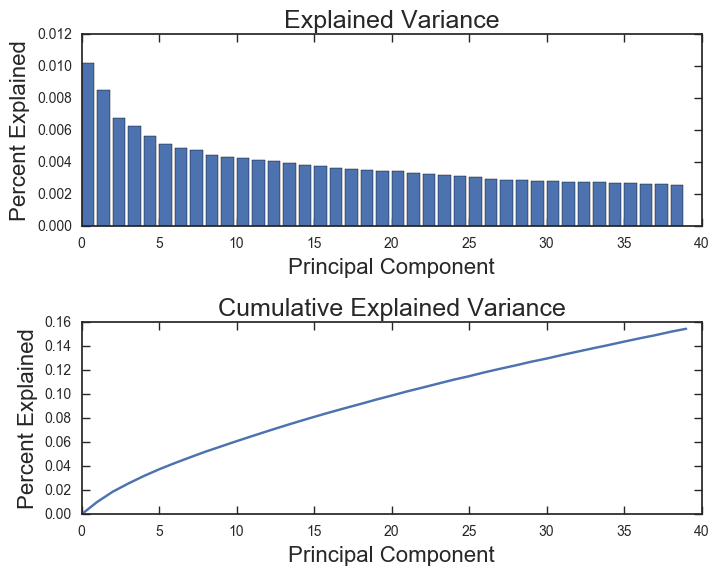

In [24]:
fig, ax = plt.subplots(2,1, figsize=(8,6))

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

# Plot of explained variance
ax1 = ax[0]
ax1.bar([x for x in range(len(pca_obj.explained_variance_ratio_))],pca_obj.explained_variance_ratio_)

ax1.set_title("Explained Variance", size=18)
ax1.set_ylabel("Percent Explained", size=16)
ax1.set_xlabel("Principal Component", size=16)

# Plot of cumulative explained variance
ax2 = ax[1]
ax2.plot([x for x in range(len(pca_variances_cum))], pca_variances_cum)

ax2.set_title("Cumulative Explained Variance", size=18)
ax2.set_ylabel("Percent Explained", size=16)
ax2.set_xlabel("Principal Component", size=16)

## Gauge how the PCA pipeline is by testing on DB Scan

In [19]:
db = DBSCAN(eps=0.5,
            min_samples=10,
            metric='euclidean')

In [20]:
pca_arr, pred_pca = get_metrics(pipe_pca, db, df_test)

SFT:  (83100, 1)
CTT:  (83100, 1)
ST:  (83100, 3)
DTST:  (83100,)
DT:  (83100, 11985)
TDFT:  (83100, 11988)
DTT:  (83100, 11987)
Number of Clusters:  1


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
pca_arr.shape

## Gauge how the NMF pipeline performs on DB Scan

In [ ]:
nmf_arr, pred_nmf = get_metrics(pipe_nmf, db, df_test)

## Gauge how the W2V pipeline performs on DB Scan

In [ ]:
w2v_arr, pred_w2v = get_metrics(pipe_w2v, db, df_test)

SFT:  (83100, 1)
SFT:  (83100, 1)
CTT:  (83100, 1)
ST:  (83100, 3)
W2V:  (83100, 300)


## Try other clustering algorithms

In [18]:
model_dict = {
    "agg": AgglomerativeClustering(n_clusters=5,
                                   affinity="cosine",
                                   linkage="complete"),
    "birch": Birch(threshold=0.5,
                   n_clusters=5,
                   branching_factor=50),
    "db": DBSCAN(eps=0.5,
                 min_samples=10,
                 metric="euclidean")
}

### Test on PCA pipeline

In [27]:
model_metrics_dict_PCA = model_metrics(model_dict, pipe_pca, df_test)

birch
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
DTST:  (4155,)
DT:  (4155, 2158)
TDFT:  (4155, 6)
DTT:  (4155, 5)
Number of Clusters:  5
Silhouette Coefficient: 0.677
agg
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
DTST:  (4155,)
DT:  (4155, 2158)
TDFT:  (4155, 6)
DTT:  (4155, 5)
Number of Clusters:  5
Silhouette Coefficient: 0.424
db
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
DTST:  (4155,)
DT:  (4155, 2158)
TDFT:  (4155, 6)
DTT:  (4155, 5)
Number of Clusters:  5
Silhouette Coefficient: 0.677


### Test on NMF pipeline

In [28]:
model_metrics_dict_NMF = model_metrics(model_dict, pipe_nmf, df_test)

birch
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
DTST:  (4155,)
DT:  (4155, 2158)
TDFT:  (4155, 6)
DTT:  (4155, 5)
Number of Clusters:  5
Silhouette Coefficient: 0.735
agg
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
DTST:  (4155,)
DT:  (4155, 2158)
TDFT:  (4155, 6)
DTT:  (4155, 5)
Number of Clusters:  5
Silhouette Coefficient: 0.536
db
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
DTST:  (4155,)
DT:  (4155, 2158)
TDFT:  (4155, 6)
DTT:  (4155, 5)
Number of Clusters:  5
Silhouette Coefficient: 0.735


### Test on W2V pipeline

In [20]:
model_metrics_dict_W2V = model_metrics(model_dict, pipe_w2v, df_test)

agg
SFT:  (41550, 1)
SFT:  (41550, 1)


KeyboardInterrupt: 

In [35]:
model_metrics_dict_W2V['birch'][1].shape

(4155,)

In [49]:
df_test2 = df_test
df_test2['cluster'] = model_metrics_dict_W2V['db'][1]
df_test2_group = df_test2.groupby(['cluster'])

In [52]:
df_test2.groupby('cluster').head()

name  rating  \
0   75                0_FourBarrelCoffee       3   
    16                0_FourBarrelCoffee       4   
    118               0_FourBarrelCoffee       5   
    11                0_FourBarrelCoffee       4   
    98                0_FourBarrelCoffee       4   
1   18498        100_ContrabandCoffeeBar       5   
    18458        100_ContrabandCoffeeBar       4   
    18519        100_ContrabandCoffeeBar       2   
    18652        100_ContrabandCoffeeBar       5   
    18602        100_ContrabandCoffeeBar       4   
2   18748              101_CafeCapriccio       5   
    18766              101_CafeCapriccio       5   
3   19620           102_BlueBottleCoffee       2   
5   19935            104_TierraMiaCoffee       3   
7   20131                    106_EightAM       2   
8   20241          107_ChaiBarByDavidRio       3   
    20393          107_ChaiBarByDavidRio       3   
9   20512   108_GoldenBearTradingCompany       1   
    20584   108_GoldenBearTradingCompany       1   
13  21071                 111_CaffeGreco       1   
15  21193                 113_BazaarCafe       2   
16  21355            114_BelloCoffee&Tea       3   
    21505            114_BelloCoffee&Tea       1   
17  21636   115_LaStazioneCoffee&WineBar       1   
19  21863               117_TheStationSF       2   
423 109764       481_EquatorCoffees&Teas       5   
468 121314                521_CafeLaTaza       5   
710 14234              73_TheSocialStudy       5   

                                                      reviews  cluster  
0   75      The first time I came in here, I felt conspicu...        0  
    16      Four Barrel is a hip and fun coffehouse. They ...        1  
    118     Wow this place gets PACKED. But still, service...        2  
    11      This place is like always busy... I stopped by...        1  
    98      Very good coffee, if you are latte lover this ...        1  
1   18498   Probably my favorite coffee in the city. They ...        2  
    18458   Nice coffee shop on nob hill with great ambian...        1  
    18519   The service was poor. I felt the barista was b...        3  
    18652   Great first impression. Barista was friendly a...        2  
    18602   Great little cafe with unique wall art. From w...        1  
2   18748   If you're looking for good, solid and quick br...        2  
    18766   I think I had one of the best mochas I've ever...        2  
3   19620   This shop opened in the neighborhood recently....        3  
5   19935   after visit to my doctor a block away, I neede...        0  
7   20131   Wait: It was full when we got here. It's a sma...        3  
8   20241   went in on a quiet Tuesday after work super ex...        0  
    20393   Was walking down this stretch of Market checki...        0  
9   20512   Overpriced deli with below-average fare for th...        4  
    20584   Came in and it took the old lady 30 minutes to...        4  
13  21071   These guys lost our order then after 20 minute...        4  
15  21193   Cute , .... Coffee wasn't all that. And if a c...        3  
16  21355   Came here with friends a while back. It's a ni...        0  
    21505   The coffee is good but the guy behind the coun...        4  
17  21636   The owner posted a response and while I apprec...        4  
19  21863   I was excited to stumble upon this really cute...        3  
423 109764             Wifi: 222 2nd St. Guest pw: Tishman222       -1  
468 121314  Shdheheheh d r shehehge dbdhhdhdr. Dhdhdhdhdhu...       -1  
710 14234   Great place for doing work while knocking back...       -1

In [51]:
df_test2.groupby('rating').count()

,name,reviews,cluster
rating,,,
1,227,227,227
2,293,293,293
3,552,552,552
4,1259,1259,1259
5,1824,1824,1824


In [44]:
df_test2_group[['name','rating','cluster']].head()

name  rating  cluster
0  75               0_FourBarrelCoffee       3        3
   16               0_FourBarrelCoffee       4        4
   118              0_FourBarrelCoffee       5        2
   11               0_FourBarrelCoffee       4        4
   98               0_FourBarrelCoffee       4        4
1  18498       100_ContrabandCoffeeBar       5        2
   18458       100_ContrabandCoffeeBar       4        4
   18519       100_ContrabandCoffeeBar       2        1
   18652       100_ContrabandCoffeeBar       5        2
   18602       100_ContrabandCoffeeBar       4        4
2  18748             101_CafeCapriccio       5        2
   18766             101_CafeCapriccio       5        2
3  19620          102_BlueBottleCoffee       2        1
5  19935           104_TierraMiaCoffee       3        3
7  20131                   106_EightAM       2        1
8  20241         107_ChaiBarByDavidRio       3        3
   20393         107_ChaiBarByDavidRio       3        3
9  20512  108_GoldenBearTradingCompany       1        0
   20584  108_GoldenBearTradingCompany       1        0
13 21071                111_CaffeGreco       1        0
15 21193                113_BazaarCafe       2        1
16 21355           114_BelloCoffee&Tea       3        3
   21505           114_BelloCoffee&Tea       1        0
17 21636  115_LaStazioneCoffee&WineBar       1        0
19 21863              117_TheStationSF       2        1

### Pickle the best performing model

#### For local computer

In [28]:
df_best = pd.DataFrame(model_metrics_dict_W2V['birch'][0], columns=['rating'] + [i for i in range(1,301)])
df_best['name'] = df_test['name'].tolist()
df_best['reviews'] = df_test['reviews'].tolist()

joblib.dump(df_best, '../data/df_best')

['../data/df_best']

#### For AWS

In [21]:
df_best = pd.DataFrame(w2v_arr, columns=['rating'] + [i for i in range(1,301)])
df_best['name'] = df_test['name'].tolist()
df_best['reviews'] = df_test['reviews'].tolist()

joblib.dump(df_best, '/home/plim0793/fletcher/df_best')

['/home/plim0793/fletcher/df_best']

In [23]:
df_best.shape

(41550, 303)